In [1]:
import pandas as pd
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt

/var/folders/js/_m5r698x29j4dvr0w18h6jdm0000gn/T/ipykernel_4813/3888494262.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
with open('intermediate_file_paths.json') as output_path_file:
    output_paths = json.load(output_path_file)

SI_PER_FIRE_INPUT_PATH = output_paths.get('stage1_si_per_fire_csv')

NORM_WT_FTRS_INPUT_PATH = output_paths.get('normalize_and_weight_features.csv')

## Future Predictions for Fire Size and Distance from Memphis 

This code processes historical fire data to calculate a 5-year rolling average of total acres burned and average distance, which is used as the basis for future predictions from 2025 to 2050. For each 5-year interval, the most recent rolling average is applied, and then the new data is incorporated into the dataset to update the rolling average, simulating trends over time. The output provides year-by-year predictions that adjust every 5 years based on historical patterns.

In [3]:
fire_data = pd.read_csv(SI_PER_FIRE_INPUT_PATH)

# Group by year and calculate sums and averages for fire size and distance
yearly_fire_data = fire_data.groupby('fire_year').agg(
    total_acres_burned_sum=('total_acres_burned', 'sum'),
    avg_distance=('distance', 'mean')
).reset_index()

# Sort by year for chronological order
yearly_fire_data = yearly_fire_data.sort_values(by='fire_year')

# Calculate a 5-year moving average for fire size and distance
yearly_fire_data['5yr_avg_acres'] = yearly_fire_data['total_acres_burned_sum'].rolling(window=5, min_periods=1).mean()
yearly_fire_data['5yr_avg_distance'] = yearly_fire_data['avg_distance'].rolling(window=5, min_periods=1).mean()

# Initialize a DataFrame to hold predictions for each year from 2025 to 2050
future_years = range(2025, 2051)
future_predictions = pd.DataFrame({
    'year': future_years,
    'predicted_total_acres_burned': np.nan,
    'predicted_avg_distance': np.nan
})

# Copy historical data into a temporary DataFrame to simulate adding future data
temp_data = yearly_fire_data.copy()

# Set the 5-year recalculation cycle
cycle_length = 5

# Loop through each year in the forecast period, applying 5-year recalculations
for i, year in enumerate(future_years):
    # Assign predictions for this year based on the latest 5-year average
    future_predictions.loc[i, 'predicted_total_acres_burned'] = temp_data['5yr_avg_acres'].iloc[-1]
    future_predictions.loc[i, 'predicted_avg_distance'] = temp_data['5yr_avg_distance'].iloc[-1]

    # Every 5 years, update rolling averages using the latest values
    if (i + 1) % cycle_length == 0:
        # Create a new row for the latest predictions as "historical" data
        new_row = pd.DataFrame({
            'fire_year': [year],
            'total_acres_burned_sum': [future_predictions.loc[i, 'predicted_total_acres_burned']],
            'avg_distance': [future_predictions.loc[i, 'predicted_avg_distance']]
        })
        
        # Concatenate the new row to `temp_data`
        temp_data = pd.concat([temp_data, new_row], ignore_index=True)

        # Recalculate the 5-year rolling averages on the updated data
        temp_data['5yr_avg_acres'] = temp_data['total_acres_burned_sum'].rolling(window=5, min_periods=1).mean()
        temp_data['5yr_avg_distance'] = temp_data['avg_distance'].rolling(window=5, min_periods=1).mean()

# Display the updated predictions with 5-year interval adjustments
print(future_predictions)


    year  predicted_total_acres_burned  predicted_avg_distance
0   2025                  2.351687e+06              359.010931
1   2026                  2.351687e+06              359.010931
2   2027                  2.351687e+06              359.010931
3   2028                  2.351687e+06              359.010931
4   2029                  2.351687e+06              359.010931
5   2030                  2.061966e+06              357.712907
6   2031                  2.061966e+06              357.712907
7   2032                  2.061966e+06              357.712907
8   2033                  2.061966e+06              357.712907
9   2034                  2.061966e+06              357.712907
10  2035                  1.700817e+06              358.135215
11  2036                  1.700817e+06              358.135215
12  2037                  1.700817e+06              358.135215
13  2038                  1.700817e+06              358.135215
14  2039                  1.700817e+06              358

## Future Predictions for Scaled Average Daily Smoke Impact

### Load the Model

In [4]:
# Load the trained Gradient Boosting model
with open('model-files/best_gradient_boosting_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

### Normalize and Weight Future Data

In [5]:
# Read the CSV file
df = pd.read_csv(NORM_WT_FTRS_INPUT_PATH)


# Set the variables from the DataFrame values
acres_weight = df.at[0, "acres_weight"]
dist_weight = df.at[0, "dist_weight"]
max_acres_burned = df.at[0, "max_total_acres_burned"]

# Convert to the appropriate data type if needed
acres_weight = float(acres_weight)
dist_weight = float(dist_weight)
max_acres_burned = float(max_acres_burned)


print(f'max_acres_burned: {max_acres_burned}, acres_weight: {acres_weight}, dist_weight: {dist_weight}')

max_distance = 650 

# Normalize and rename the future prediction features
future_predictions['total_acres_burned_normalized'] = future_predictions['predicted_total_acres_burned'] / max_acres_burned

future_predictions['distance_normalized'] = future_predictions['predicted_avg_distance'] / max_distance

future_predictions['total_acres_burned_weighted'] = future_predictions['total_acres_burned_normalized'] * acres_weight
future_predictions['distance_weighted'] = future_predictions['distance_normalized'] * dist_weight


max_acres_burned: 4859569.981645179, acres_weight: 1.0, dist_weight: 1.0


### Make the model predictions

In [6]:
# Prepare future prediction data for smoke impact
X_future = future_predictions[['total_acres_burned_weighted', 'distance_weighted']]

# Predict smoke impact for each year using the model
future_predictions['predicted_smoke_impact'] = model.predict(X_future)

# Display the predictions for smoke impact from 2025 to 2050
print(future_predictions[['year', 'predicted_total_acres_burned', 'predicted_avg_distance', 'predicted_smoke_impact']])

    year  predicted_total_acres_burned  predicted_avg_distance  \
0   2025                  2.351687e+06              359.010931   
1   2026                  2.351687e+06              359.010931   
2   2027                  2.351687e+06              359.010931   
3   2028                  2.351687e+06              359.010931   
4   2029                  2.351687e+06              359.010931   
5   2030                  2.061966e+06              357.712907   
6   2031                  2.061966e+06              357.712907   
7   2032                  2.061966e+06              357.712907   
8   2033                  2.061966e+06              357.712907   
9   2034                  2.061966e+06              357.712907   
10  2035                  1.700817e+06              358.135215   
11  2036                  1.700817e+06              358.135215   
12  2037                  1.700817e+06              358.135215   
13  2038                  1.700817e+06              358.135215   
14  2039  

/Users/debbiesubocz/anaconda3/envs/512_proj/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


## Prediction Graph

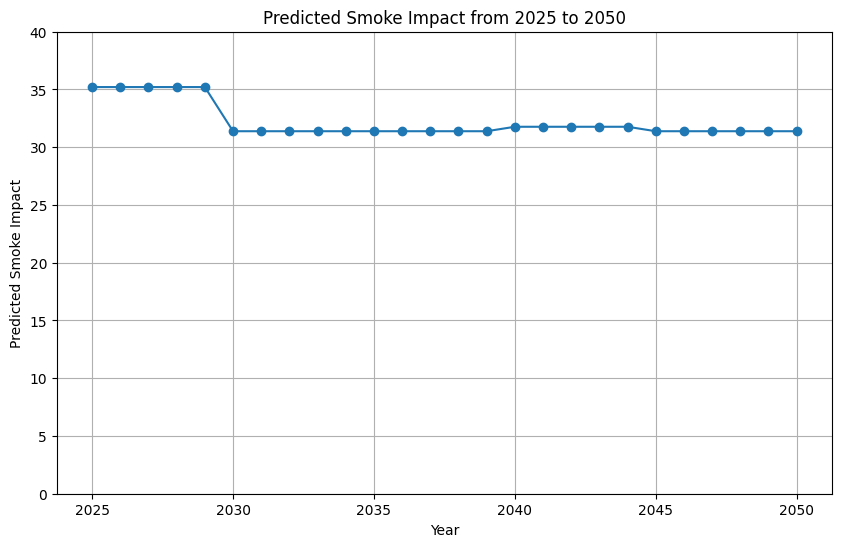

In [44]:
# Plot predicted smoke impact
plt.figure(figsize=(10, 6))
plt.plot(future_predictions['year'], future_predictions['predicted_smoke_impact'], label='Predicted Smoke Impact', linestyle='-', marker='o')

# Add titles and labels
plt.title('Predicted Smoke Impact from 2025 to 2050')
plt.xlabel('Year')
plt.ylabel('Predicted Smoke Impact')
plt.ylim(0, 40)  # Set y-axis to start at 0
plt.grid(True)

# Display the plot
plt.show()
